In [6]:
import PyPDF2
import re
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import os,json
import numpy as np
import nltk

In [7]:
class convertCVtoText:
    @staticmethod
    def startConversion(fileName):
        pdfFileObj = open(fileName,'rb')     #'rb' for read binary mode
        pdfReader = PyPDF2.PdfFileReader(pdfFileObj)
        noOfPages=pdfReader.numPages
        text=""
        for pages in range(0,pdfReader.numPages):
            pageObj = pdfReader.getPage(pages)          #'9' is the page number
            text+=pageObj.extractText()
        return text

In [8]:
class textCleaner:
    def __init__(self):
        self.text=""
        self.cleanText=""
    def normalizeText(self):
        norText=""
        returnText=""
        norText+= re.sub(r'[^a-zA-Z ]',r' ',self.text)
        returnText+=re.sub(' +',' ',norText)
        self.cleanText+=re.sub(r'([A-Z])', lambda pat: pat.group(1).lower(), returnText)
       
                
        
        

In [9]:
class CV:
     def __init__(self,name,path,post):
            self.fileName=name
            self.filePath=path
            self.CVCategory=post
            self.textHandeller=textCleaner()
            self.textHandeller.text=convertCVtoText.startConversion(self.filePath)
            self.textHandeller.normalizeText()
            self.featureVector=[]
            self.score=None
            self.frequencyVector=[]
            
            
       

In [10]:
import numpy as np
from sklearn.metrics.pairwise import pairwise_distances
from skfeature.utility.util import reverse_argsort
class refiefFAlgo:
    def __init__(self,mode=None):
        self.scoreList=[]
        self.wordIndex=[]
        self.mode=mode
    def feature_ranking(self):
            """
            Rank features in descending order according to reliefF score, the higher the reliefF score, the more important the
            feature is
            """
            for scorePerCluster in self.scoreList:
                temp=np.asarray(scorePerCluster) 
                idx = np.argsort(temp, 0)
            #print(idx)
            self.wordIndex.append(idx[::-1])
            #return idx[::-1]
    def score_ranking(self):
            """
            Rank features in descending order according to reliefF score, the higher the reliefF score, the more important the
            feature is
            """
            for scorePerCluster in self.scoreList:
                temp=np.asarray(scorePerCluster) 
                idx = np.argsort(temp, 0)
            #print(idx)
            self.wordIndex.append(idx[::-1])
            #return idx[::-1]
    def reliefF(self,X, y,**kwargs):
        """
        This function implements the reliefF feature selection

        Input
        -----
        X: {numpy array}, shape (n_samples, n_features)
            input data
        y: {numpy array}, shape (n_samples,)
            input class labels
        kwargs: {dictionary}
            parameters of reliefF:
            k: {int}
                choices for the number of neighbors (default k = 5)

        Output
        ------
        score: {numpy array}, shape (n_features,)
            reliefF score for each feature

        Reference
        ---------
        Robnik-Sikonja, Marko et al. "Theoretical and empirical analysis of relieff and rrelieff." Machine Learning 2003.
        Zhao, Zheng et al. "On Similarity Preserving Feature Selection." TKDE 2013.
        """


        if "k" not in list(kwargs.keys()):
            k = 5
        else:
            k = kwargs["k"]
        n_samples, n_features = X.shape

        # calculate pairwise distances between instances
        distance = pairwise_distances(X, metric='manhattan')



        # the number of sampled instances is equal to the number of total instances
        for idx in range(n_samples):
            score = np.zeros(n_features)
            near_hit = []
            near_miss = dict()

            self_fea = X[idx, :]
            c = np.unique(y).tolist()

            stop_dict = dict()
            for label in c:
                stop_dict[label] = 0
            del c[c.index(y[idx])]

            p_dict = dict()
            p_label_idx = float(len(y[y == y[idx]]))/float(n_samples)

            for label in c:
                p_label_c = float(len(y[y == label]))/float(n_samples)
                p_dict[label] = p_label_c/(1-p_label_idx)
                near_miss[label] = []

            distance_sort = []
            distance[idx, idx] = np.max(distance[idx, :])

            for i in range(n_samples):
                distance_sort.append([distance[idx, i], int(i), y[i]])
            distance_sort.sort(key=lambda x: x[0])

            for i in range(n_samples):
                # find k nearest hit points
                if distance_sort[i][2] == y[idx]:
                    if len(near_hit) < k:
                        near_hit.append(distance_sort[i][1])
                    elif len(near_hit) == k:
                        stop_dict[y[idx]] = 1
                else:
                    # find k nearest miss points for each label
                    if len(near_miss[distance_sort[i][2]]) < k:
                        near_miss[distance_sort[i][2]].append(distance_sort[i][1])
                    else:
                        if len(near_miss[distance_sort[i][2]]) == k:
                            stop_dict[distance_sort[i][2]] = 1
                stop = True
                for (key, value) in list(stop_dict.items()):
                        if value != 1:
                            stop = False
                if stop:
                    break

            # update reliefF score
            near_hit_term = np.zeros(n_features)
            for ele in near_hit:
                near_hit_term = np.array(abs(self_fea-X[ele, :]))+np.array(near_hit_term)

            near_miss_term = dict()
            for (label, miss_list) in list(near_miss.items()):
                near_miss_term[label] = np.zeros(n_features)
                for ele in miss_list:
                    near_miss_term[label] = np.array(abs(self_fea-X[ele, :]))+np.array(near_miss_term[label])
                score += near_miss_term[label]/(k*p_dict[label])
            score -= near_hit_term/k
            self.scoreList.append(score)
            self.feature_ranking()
        if self.mode == 'raw':
            print("here")
            print(score)
            return score
        elif self.mode == 'index':
            print("herew")
            return feature_ranking(score)
        elif self.mode == 'rank':
            print("hereq")
            return reverse_argsort(feature_ranking(score), X.shape[1])




In [11]:
class CBRAlgo:
    def __init__(self):
        self.CVScoreList=[]
        self.topWords=None
        self.clusterWiseTopWordList=[]
        self.overAllWeight=[]
    def getTopWords(self,vocabulary,clusterCenters,noOfFormedClusters):
        x=[]
        for key,values in vocabulary.items():
            x.append(values)  
        self.topWords=refiefFAlgo()
        self.topWords.reliefF(clusterCenters,np.asarray(x),k=noOfFormedClusters-1)
        
    def getOverallWeightOfRelevantWords(self):
        self.overAllWeight=np.average([x for x in self.topWords.scoreList],axis=0)
        
    def calculateCVScoreViaCluster(self,documentMatrix,vocabulary,clusteringInfo):
        self.getTopWords(vocabulary,clusteringInfo.kMeans.cluster_centers_,clusteringInfo.bestClusterToForm)
        self.getTopWordsPerCluster(clusteringInfo.kMeans.cluster_centers_,vocabulary)
        self.getOverallWeightOfRelevantWords()
        featureVector=documentMatrix.toarray()
        for cvNumber,clusterNumber in enumerate(clusteringInfo.kMeans.labels_):
            score=0
            for wordFrequency,weight in zip(featureVector[cvNumber],self.topWords.scoreList[clusterNumber]):
                score+=wordFrequency*weight
            self.CVScoreList.append(score)    
            
    def calculateCVScore(self,documentMatrix,vocabulary,clusteringInfo):
        self.getTopWords(vocabulary,clusteringInfo.kMeans.cluster_centers_,clusteringInfo.bestClusterToForm)
        self.getTopWordsPerCluster(clusteringInfo.kMeans.cluster_centers_,vocabulary)
        self.getOverallWeightOfRelevantWords()
        featureVector=documentMatrix.toarray()
        for cvNumber,clusterNumber in enumerate(clusteringInfo.kMeans.labels_):
            score=0
            for wordFrequency,weight in zip(featureVector[cvNumber],self.overAllWeight):
                score+=wordFrequency*weight
            self.CVScoreList.append(score)    
            
    def getTopWordsPerCluster(self,clusterCenters,vocabulary):
        for clusterNo,impFeaturesRow in enumerate(clusterCenters):
            WordList={}
            for indexNo in self.topWords.wordIndex[clusterNo]:
                WordList.update({list(vocabulary.keys())[list(vocabulary.values()).index(indexNo)]:self.topWords.scoreList[clusterNo][indexNo]})
            self.clusterWiseTopWordList.append(WordList)
    def plotTopWordsPerCluster(self):
        topwords=10
        width =1
        import matplotlib.pyplot as plt
        for index,clusterTopWord in enumerate(self.clusterWiseTopWordList):
            ig,ax = plt.subplots()
            lists = [(key,value) for (key,value) in clusterTopWord.items()] # sorted by key, return a list of tuples
            key, value = zip(*lists)
            x = np.arange(topwords)
            plt.barh(x[:topwords],value[:topwords],align='center')
            plt.yticks(x, key[:topwords])
            plt.rcParams["figure.figsize"] = (10,10)
            plt.title('top %d words in %d cluster'%(topwords,index))
            plt.ylabel('words')
            plt.xlabel('weight')
            plt.show()
    def plotOverAllWeight(self,vocabulary):
        import matplotlib.pyplot as pl
        ig,ax = plt.subplots()
        x = np.arange(0,len(self.overAllWeight))
        pl.barh(x,self.overAllWeight,align='center')
        pl.yticks(x,vocabulary)
        pl.rcParams["figure.figsize"] = (20,20)
        pl.title('weight bar graph of Relevant words')
        pl.ylabel('words')
        pl.xlabel('weight')          
        pl.show()


In [12]:
class NLTKHelper:
    def __init__(self):
        self.documentMatrix=None
        self.vocabulary=None
        self.normalizedFeatureSet=[]
    def findDocumentMatrix(self,totalCVText,minFrequency,vocab):
        #vectorizer=CountVectorizer(stop_words='english',min_df=minFrequency)
        vectorizer=CountVectorizer(stop_words='english',vocabulary=vocab)
        #vectorizer=CountVectorizer(stop_words='english')
        self.documentMatrix=vectorizer.fit_transform(totalCVText)
        self.vocabulary=vectorizer.vocabulary_
        #return documentMatrix,vocabulary 
        self.normalizeMatrix()
    def normalizeMatrix(self):
        self.normalizedFeatureSet=normalize(self.documentMatrix.toarray().astype('float64'))
        

In [13]:
class Clustering:
    def __init__(self):
        self.kMeans=None
        self.bestClusterToForm=None
        self.silCoeffInfo={}
        self.minCluster=2
        self.maxCluster=10
    def findSilCoeff(self,data):
        for n_cluster in range(self.minCluster, self.maxCluster):
            kmeans = KMeans(n_clusters=n_cluster).fit(data)
            label = kmeans.labels_
            sil_coeff = silhouette_score(data, label, metric='euclidean')
            self.silCoeffInfo.update({n_cluster:float(sil_coeff)})
        maxSilCoeff=max(self.silCoeffInfo.values())
        maxSilCoeffkeys = [k for k, v in self.silCoeffInfo.items() if v == maxSilCoeff]
        if(len(maxSilCoeffkeys)==1):
            for x in maxSilCoeffkeys:
                self.bestClusterToForm=x
        else:
            print("2 keys,confusion")
    def clusterData(self,data):
        self.findSilCoeff(data)
        self.kMeans=KMeans(n_clusters=self.bestClusterToForm).fit(data)

In [14]:
class CVManager:
    def __init__(self):
        self.CVList=[]
        self.cvsFile="documentMatrix.csv"
        self.CVFileName=[]
        self.fileNamesWithPath=[]
        self.cvPostList=[]
        self.CVTextColl=[]
        self.noOfTopCV=10
        self.orderedCVList=[]
        self.languageProcessing=None
        self.clusteringInfo=None
        self.CVRanker=None
    def list_CVs(self,rootPath):
          
        for root, dirs, files in os.walk(rootPath):
            for name in files:
                self.CVFileName.append(name)
                self.fileNamesWithPath.append(os.path.join(root, name))
                self.cvPostList.append(os.path.basename(os.path.dirname(os.path.join(root,name))))
               
    def collectCV(self):
            for cvFilePath,cvFileName,cvPost in zip(self.fileNamesWithPath,self.CVFileName,self.cvPostList):
                try:
                    newCV=CV(cvFileName,cvFilePath,cvPost)
                    self.CVList.append(newCV)
                except Exception as e:
                    print(cvFileName)
                    print("in collection of CV \t"+str(e))
            
    def collectCVText(self):
        self.CVTextColl=[]
        for cv in self.CVList:
            self.CVTextColl.append(cv.textHandeller.cleanText) 
    def findDocumentMatrix(self,minFrequency,vocab):
            self.collectCVText()
            self.languageProcessing=NLTKHelper()
            self.languageProcessing.findDocumentMatrix(self.CVTextColl,minFrequency,vocab)
            self.assignFeatureVector()  
    def assignFeatureVector(self):
        for cv,cvNum in zip(self.CVList,range(len(self.CVFileName))):
            cv.featureVector=self.languageProcessing.normalizedFeatureSet[cvNum]
        for cv,cvNum in zip(self.CVList,range(len(self.CVFileName))):
            cv.frequencyVector=self.languageProcessing.documentMatrix.toarray()[cvNum]
            #frequencyVector
    def makeGraph(self,data):
        lists = sorted(data) # sorted by key, return a list of tuples
        x, y = zip(*lists) # unpack a list of pairs into two tuples
        plt.plot(x, y)
        plt.show()
        
    def clusterData(self):
        self.clusteringInfo=Clustering()
        self.clusteringInfo.clusterData(self.languageProcessing.normalizedFeatureSet)
        self.makeGraph(self.clusteringInfo.silCoeffInfo.items())
    def rankCV(self):
        self.CVRanker=CBRAlgo()
        self.CVRanker.calculateCVScore(self.languageProcessing.documentMatrix,self.languageProcessing.vocabulary,self.clusteringInfo)
        for cv,cvScore in zip(self.CVList,self.CVRanker.CVScoreList):
            cv.score=cvScore
    def showAnalytics(self):
        self.CVRanker.plotTopWordsPerCluster()
        self.CVRanker.plotOverAllWeight(self.languageProcessing.vocabulary)
    def showTopCVPerPost(self,post):
        cvlist={}
        cvScore=[]
        cvData=[]
        if post is None:
            for cvCategery in set(self.cvPostList):
                cvlist={}
                print("cv of %s"%cvCategery)
                for cv in self.CVList:
                    if(cv.CVCategory==cvCategery):
                        cvlist.update({cv:cv.score})
                temp=[(value,key) for key,value in cvlist.items()]
                temp.sort()
                temp.reverse()
                temp=[(key,value) for value,key in temp]
                cvData=temp
                return cvData
        else:
            try:
                print("cv of post %s"%post)
                for cv in self.CVList:
                    if(cv.CVCategory==post):
                        cvlist.update({cv:cv.score})
                temp=[(value,key) for key,value in cvlist.items()]
                temp.sort()
                temp.reverse()
                temp=[(key,value) for value,key in temp]
                cvData=temp
                return cvData
            except Exception as e:
                    print(cv.fileName)
                    print("finding top CV \t"+str(e))
            
    def compareCV(self):
        topCVNum=2
        cvIndex=0
        #print(self.orderedCVList)
        for cv in self.orderedCVList[:topCVNum]:
            xValue = np.arange(len(cv[cvIndex].frequencyVector))
            plt.plot(xValue,cv[cvIndex].frequencyVector, markersize = 10,label=cv[cvIndex].fileName+'='+str(cv[cvIndex].score))
            #plt.rcParams["figure.figsize"] = (10,20)
        plt.title('CV comparision top cv')
        plt.ylabel('Feature Vector Frequency')
        plt.legend(mode="expand")
        plt.xlabel('Relevant words index')
        #plt.rcParams["figure.figsize"] = (10,10)
        plt.show()
        for cv in self.orderedCVList[int(len(self.orderedCVList)/2)-1:int(len(self.orderedCVList)/2)+1]:
            xValue = np.arange(len(cv[cvIndex].frequencyVector))
            plt.plot(xValue,cv[cvIndex].frequencyVector, markersize = 10,label=cv[cvIndex].fileName+'='+str(cv[cvIndex].score))
        plt.title('CV comparision middle CV')
        plt.ylabel('Feature Vector Frequency')
        plt.legend(mode="expand")
        plt.xlabel('Relevant words index')
        #plt.rcParams["figure.figsize"] = (10,10)
        plt.show()
        for cv in self.orderedCVList[-2:]:
            xValue = np.arange(len(cv[cvIndex].frequencyVector))
            plt.plot(xValue,cv[cvIndex].frequencyVector, markersize = 10,label=cv[cvIndex].fileName+'='+str(cv[cvIndex].score))
        plt.title('CV comparision last CV')
        plt.ylabel('Feature Vector Frequency')
        plt.legend(mode="expand")
        plt.xlabel('Relevant words index')
        #plt.rcParams["figure.figsize"] = (10,10)
        plt.show()
       
            


In [15]:
class communicationInformation:
    def __init__(self):
        self.directoryPath=""
        self.relevantWords=[]
        self.jobSelected=""
        self.workFlow=True
        relevantWords1=[
      'css',
   'design',
  'html',
  'javascript',
 'jquery',
 'mysql',
  'ajax',
     'php',
    'animation','adobe','flash','character','art','illustrator','design','animator','effects','maya','photoshop',
    
   "software","skills","application","developer","server",
   "systems","framework","net","visual",
    
     "algorithm","analyst","aws","datasets","clustering","intelligence","logistic","mining","neural","regression","scikit"

]
        self.relevantWords=list(set(relevantWords1))

In [16]:
import webbrowser
import random
class buttonHandler:
    def __init__(self, master,buttonDataList):
        self.buttonList=[]
        self.frame = Frame(master)
        self.frame.pack()
        vhdlWork=[]
        f=open("F:\\VHDL\\text.txt","w")
        for buttonName in buttonDataList:
                buttonToShow=Button(self.frame,text=str(buttonName[0].fileName),command=lambda:self.openPdf(buttonName[0].filePath))
                #f.write(
                value=str(str(buttonName[0].fileName[:10])+" "+str(int(buttonName[1]))+"\n")
                vhdlWork.append(value)
                buttonToShow.pack(padx=5,pady=10)
                self.buttonList.append(buttonToShow)
        random.shuffle(vhdlWork)
        for eachLine in vhdlWork:
            f.write(eachLine)
        f.close()
        print(vhdlWork)
    def openPdf(self,link):
        webbrowser.open_new_tab(link) 
    def destoringButtons(self):
        self.frame.destroy()
        
    

In [17]:
from tkinter import*
import tkinter.filedialog 
from tkinter import Tk, StringVar, ttk
import webbrowser

class GUI:
    def __init__(self,root):
        self.passingInfo=communicationInformation()
        self.root=root
        self.run=False
        self.frame = Frame()
        self.frame.pack(fill=X)
        self.directoryLabel = Label(self.frame,text="Path",  width=10)
        self.directoryLabel.pack(side=LEFT)
        self.directoryEntry = Entry(self.frame,width=100)
        self.directoryEntry.pack(side=LEFT, padx=0,pady=10 ,expand=True)
        self.addDirectoryButton = Button(self.root, text ="     Add    ",command=self.pathAdd)
        self.addDirectoryButton.pack(padx=5,pady=10)
        self.buttonList=None
        self.jobReqFrame = Frame()
        self.jobReqFrame.pack(side=LEFT,fill=X)        
        self.jobRequirementLabel  = Label(self.jobReqFrame, text="Jobs Requirements", width=50)
        self.jobRequirementLabel.pack(expand=True, padx=5, pady=5)     
        self.relevantWordsText = Text(self.jobReqFrame,width=40,height=15)
        self.relevantWordsText.pack( side=LEFT,pady=5, padx=5)
        self.relevantWordsText.insert('1.0',' '.join(self.passingInfo.relevantWords))
        self.CVTitleFrame=Frame()
        self.CVTitleFrame.pack(fill=X)
        self.CVTitleLabel = Label(self.CVTitleFrame, text="Selecte Post", width=50)
        self.CVTitleLabel.pack( anchor=N, padx=0, pady=0)
        
        self.topCVDisplay = Frame()
        self.topCVDisplay.pack(fill=X,padx=50)
        self.box_value = StringVar()
        self.box = ttk.Combobox(self.topCVDisplay, textvariable=self.box_value,state='readonly')
        self.box['values'] = ( 'animator','webDeveloper','SoftwareDeveloper','')
        self.box.grid(column=0, row=0)
        #process button
        self.processButton = Button(self.jobReqFrame, text ="    Process    ",command=self.processExe)
        self.processButton.pack(side=LEFT,padx=10,pady=10)
        self.analyze=None
        self.exitButton = Button(self.root, text ="    Exit    ",command=self.root.destroy)
        self.exitButton.pack(side=LEFT,padx=10,pady=10)
        self.manager=CVManager()

    def pathAdd(self):
        directoryPath=filedialog.askdirectory()
        self.directoryEntry.insert(0, directoryPath)
        
    def processExe(self):
        if(not(self.run)):
            self.passingInfo.directoryPath=self.directoryEntry.get()
            self.passingInfo.jobSelected=self.box.get()
            if self.passingInfo.workFlow:   
                try:
                    self.run=True
                    self.manager.list_CVs(self.passingInfo.directoryPath)
                    self.manager.collectCV()
                    self.manager.findDocumentMatrix(None,self.passingInfo.relevantWords)
                    self.manager.clusterData()
                    self.manager.rankCV()
                    self.manager.showAnalytics()
                    self.manager.orderedCVList=self.manager.showTopCVPerPost(self.passingInfo.jobSelected)
                    self.analyze = Button(self.root, text ="analyze",command=self.analyzeCV)
                    self.analyze.pack(side=LEFT,padx=10,pady=10)
                    self.createLinkToCV(self.manager.orderedCVList)
                    
                except Exception as e:
                    print("error")
                    print("processing \t"+str(e))
            else:
                print("select all necessary info")
        else:
            try:
                self.passingInfo.jobSelected=self.box.get()
                self.manager.orderedCVList=self.manager.showTopCVPerPost(self.passingInfo.jobSelected)
                self.buttonList.destoringButtons()
                self.createLinkToCV(self.manager.orderedCVList)
            except Exception as e:
                    print("error")
                    print("processing second time \t"+str(e))
    def createLinkToCV(self,dataList):
        self.buttonList=buttonHandler(self.root,dataList)
    def analyzeCV(self):
        self.manager.compareCV()
        

   


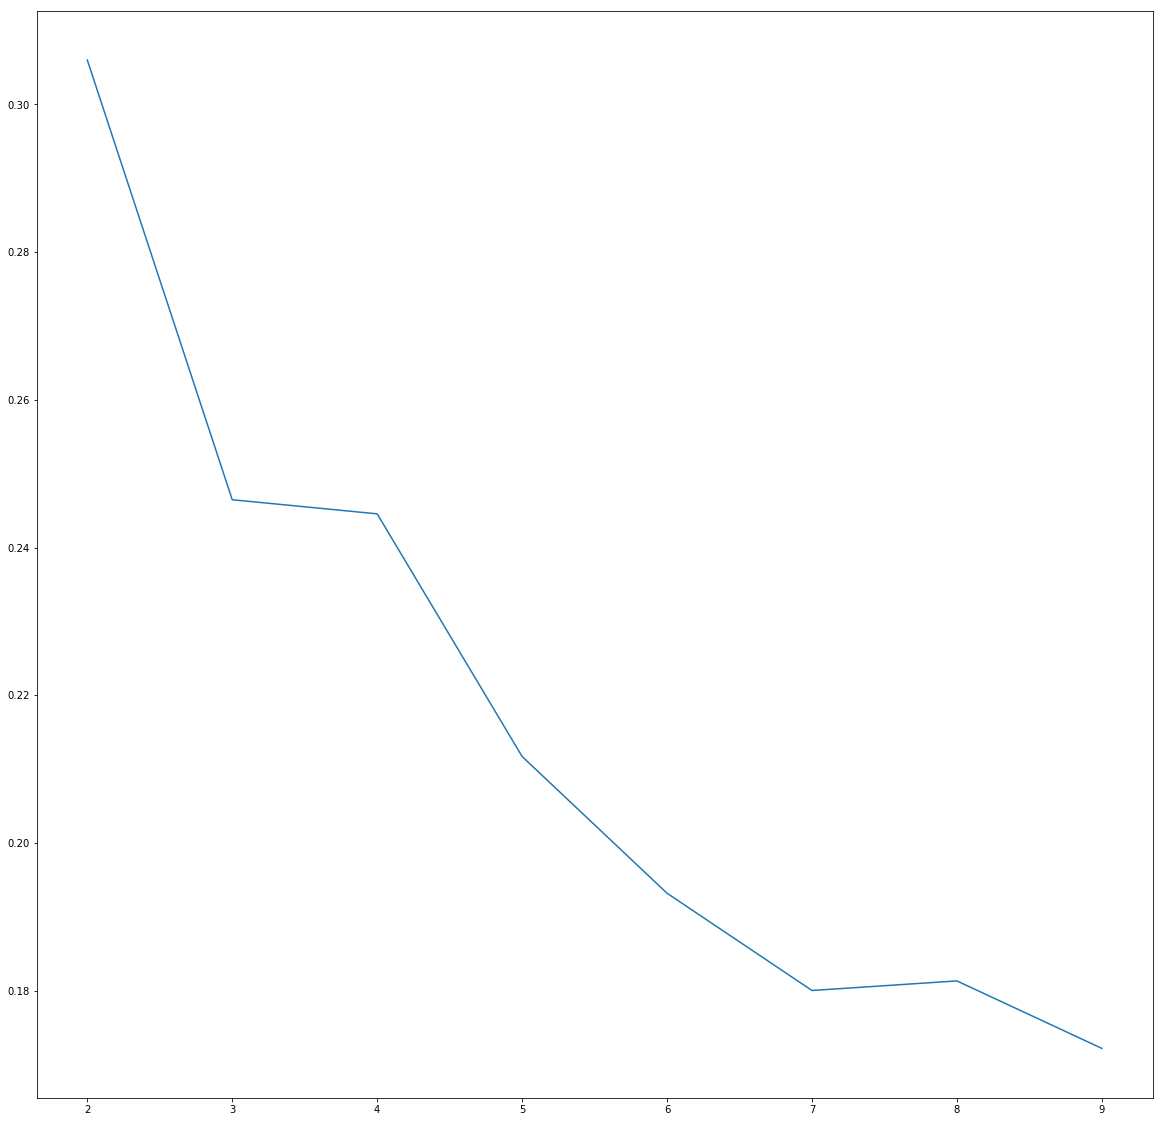

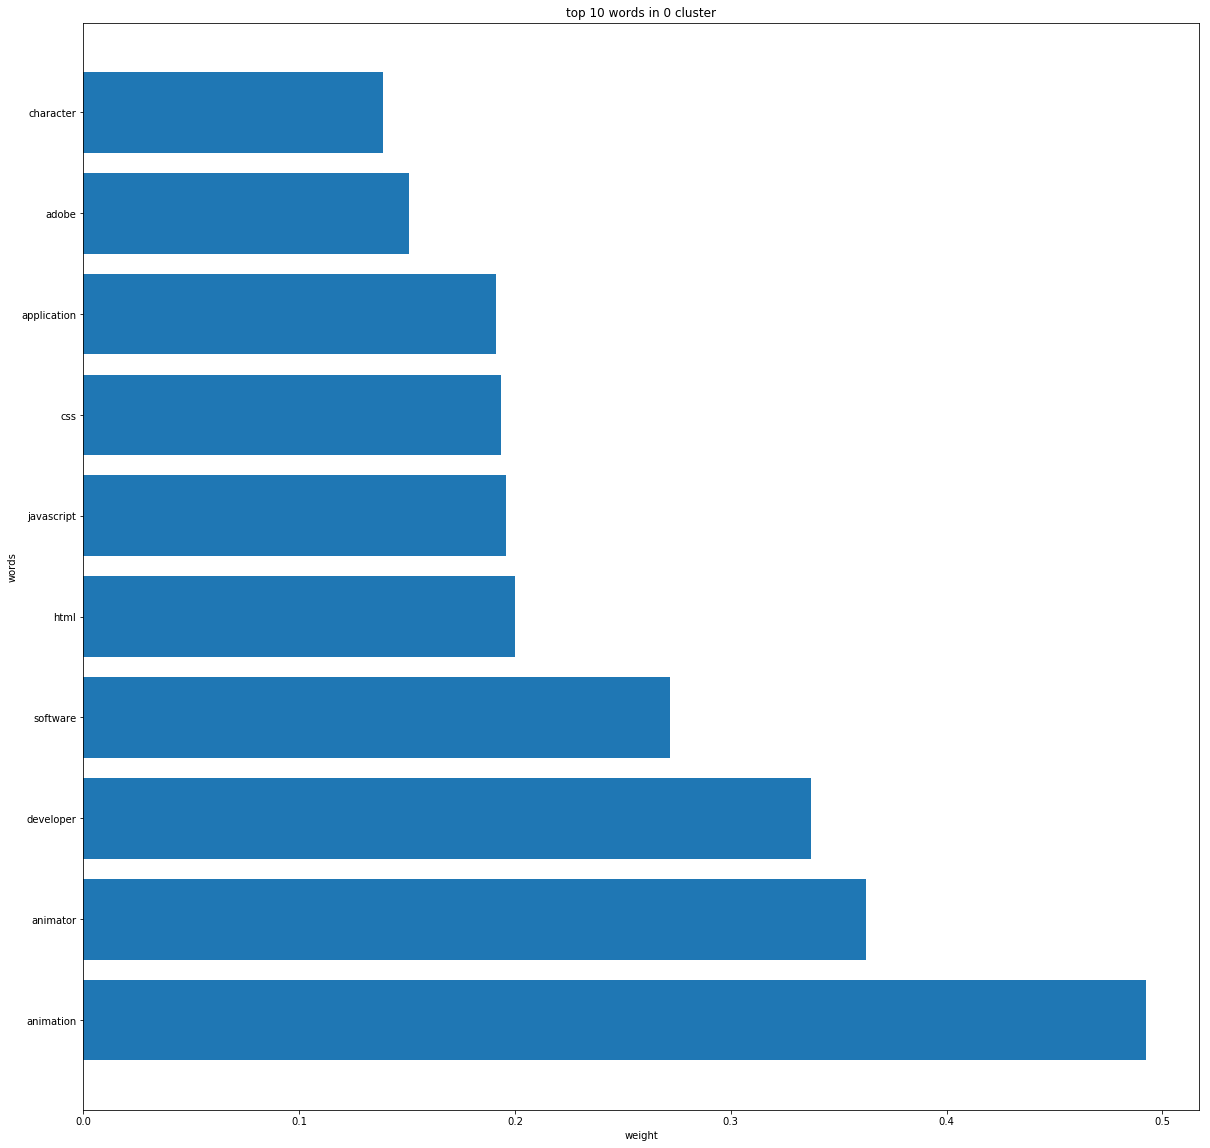

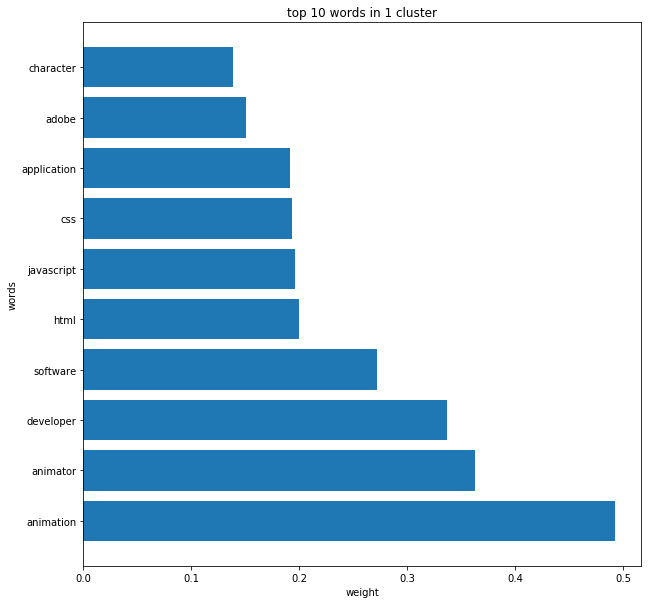

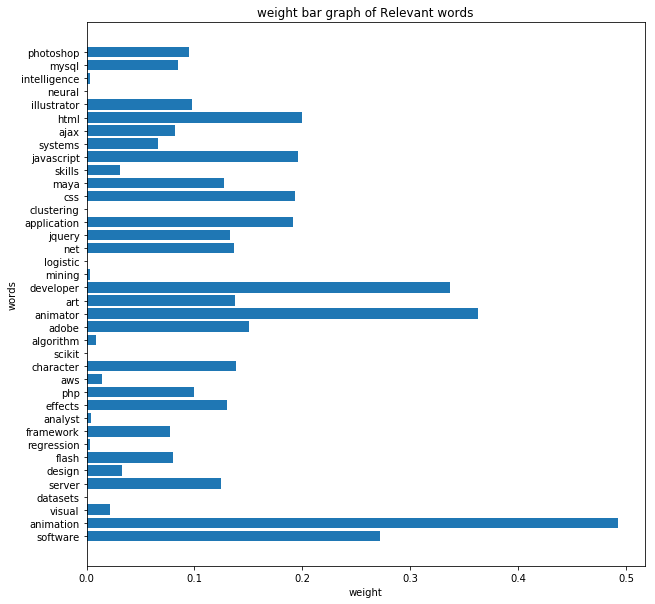

cv of post animator
['Jorge-Dela 7\n', 'Sarah-Talb 5\n', 'John-Wong. 22\n', 'Oliver-Wad 13\n', 'Gianna-Cap 4\n', 'Brandon-Za 2\n', 'Remon-Dawo 3\n', 'Steven-Bow 3\n', 'Paul-V.pdf 1\n', 'Heather-Cl 4\n', 'Molly-Sota 2\n', 'Natalie-Ab 6\n', 'Wes-Bernic 7\n', 'Paul-Clark 10\n', 'Oleksandra 5\n', 'Julia-Vela 4\n', 'Brandon-Bu 3\n', 'Alexandria 2\n', 'Gavin-Wrig 5\n', 'Laura-Tull 8\n', 'Alexius-Bu 2\n', 'Elif-Kaner 10\n', 'Bradford-U 7\n', 'Simon-H.-Y 17\n', 'Emily-Brix 2\n', 'Ryan-Chapm 2\n', 'Scott-Hill 2\n', 'Vikki-Cour 2\n', 'Stephanie- 2\n', 'Monica-Sef 8\n', 'Amari-Hark 9\n', 'Benjamin-R 5\n', 'Marcela-Ga 4\n', 'Cameron-Le 1\n', 'Matthew-Au 4\n', 'Sharp-Phot 1\n', 'Jarvis-Bro 8\n', 'Vanessa-La 4\n', 'Michael-Cu 6\n', 'Brian-Burk 13\n', 'Michael-Ma 11\n', 'Isaac-Avit 6\n', 'Nathen-Gro 5\n', 'Robert-Han 16\n', 'Erik-Edmon 3\n', 'Troy-Lai.p 4\n', 'Chun-Chieh 6\n', 'James-Arvi 9\n', 'Abanti-Cho 3\n', 'Carlos-Vel 2\n', 'Tod-Deppe. 4\n', 'Michael-Ry 30\n', 'Miranda-Fe 3\n', 'Elizabeth- 5\n'

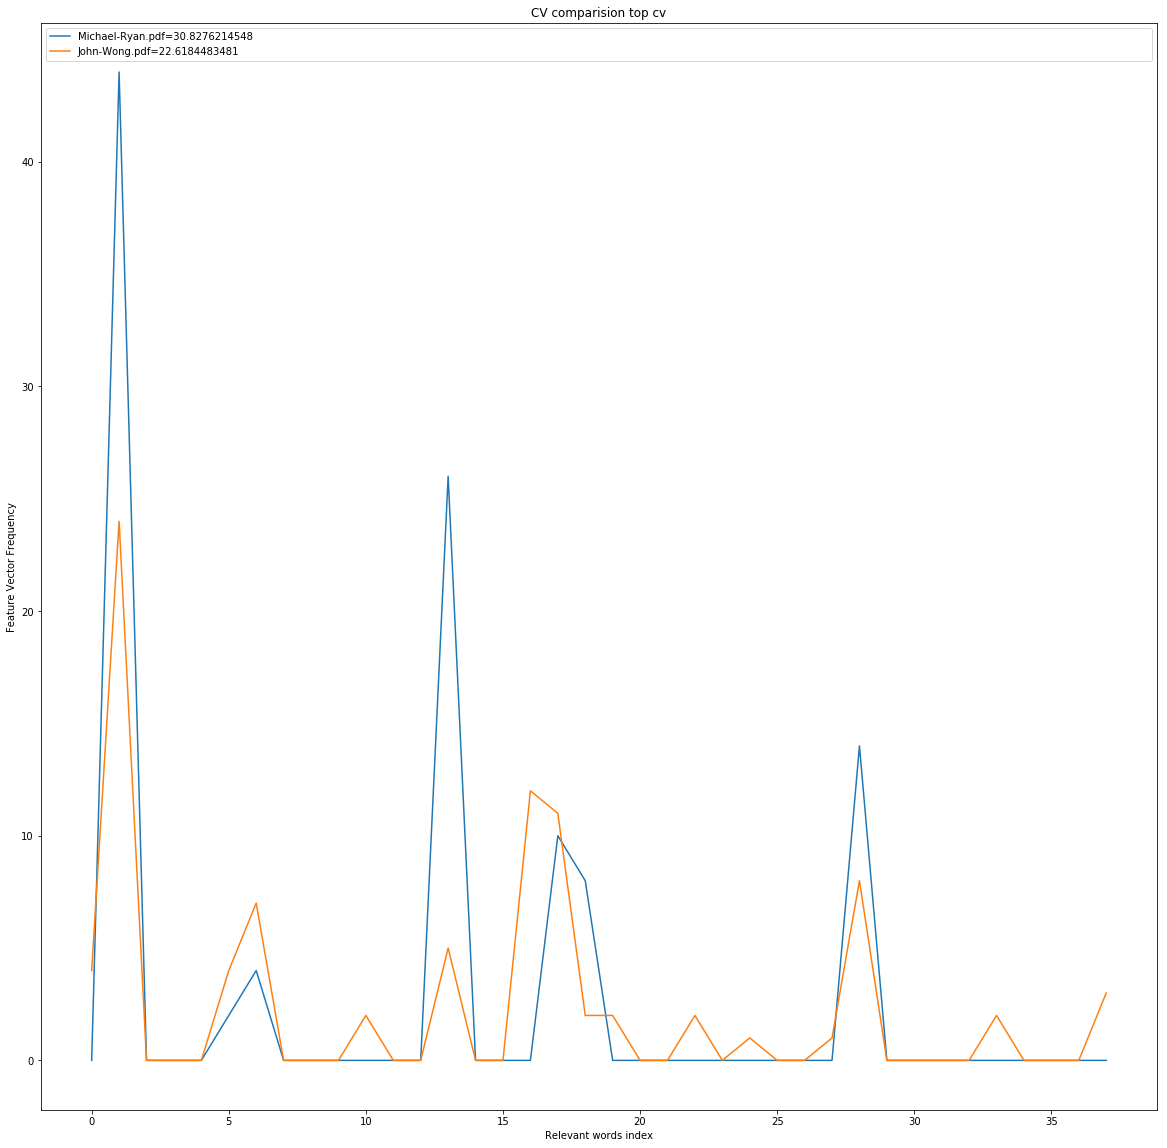

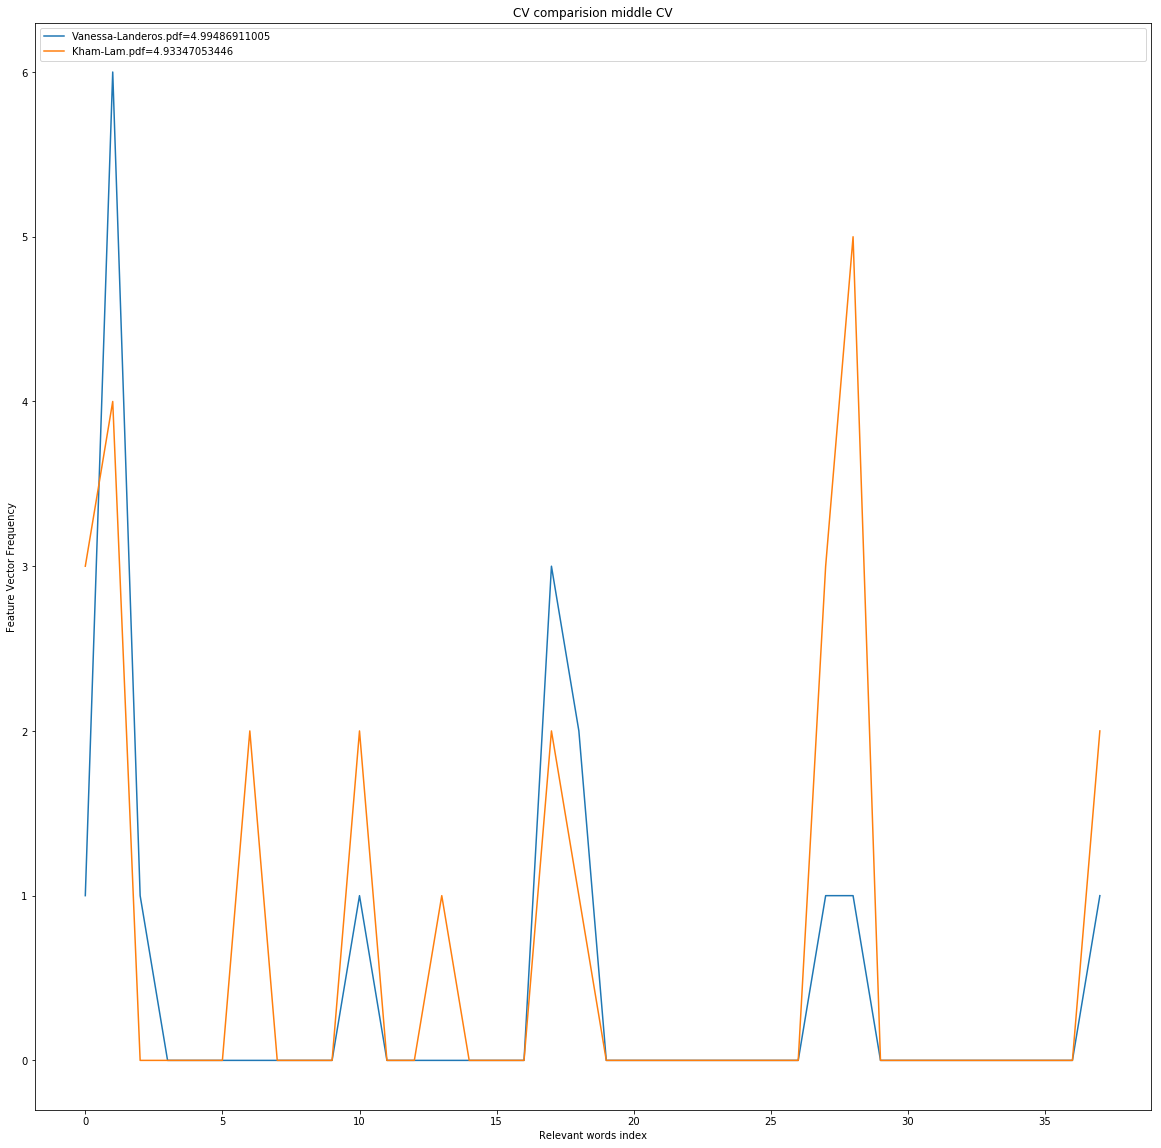

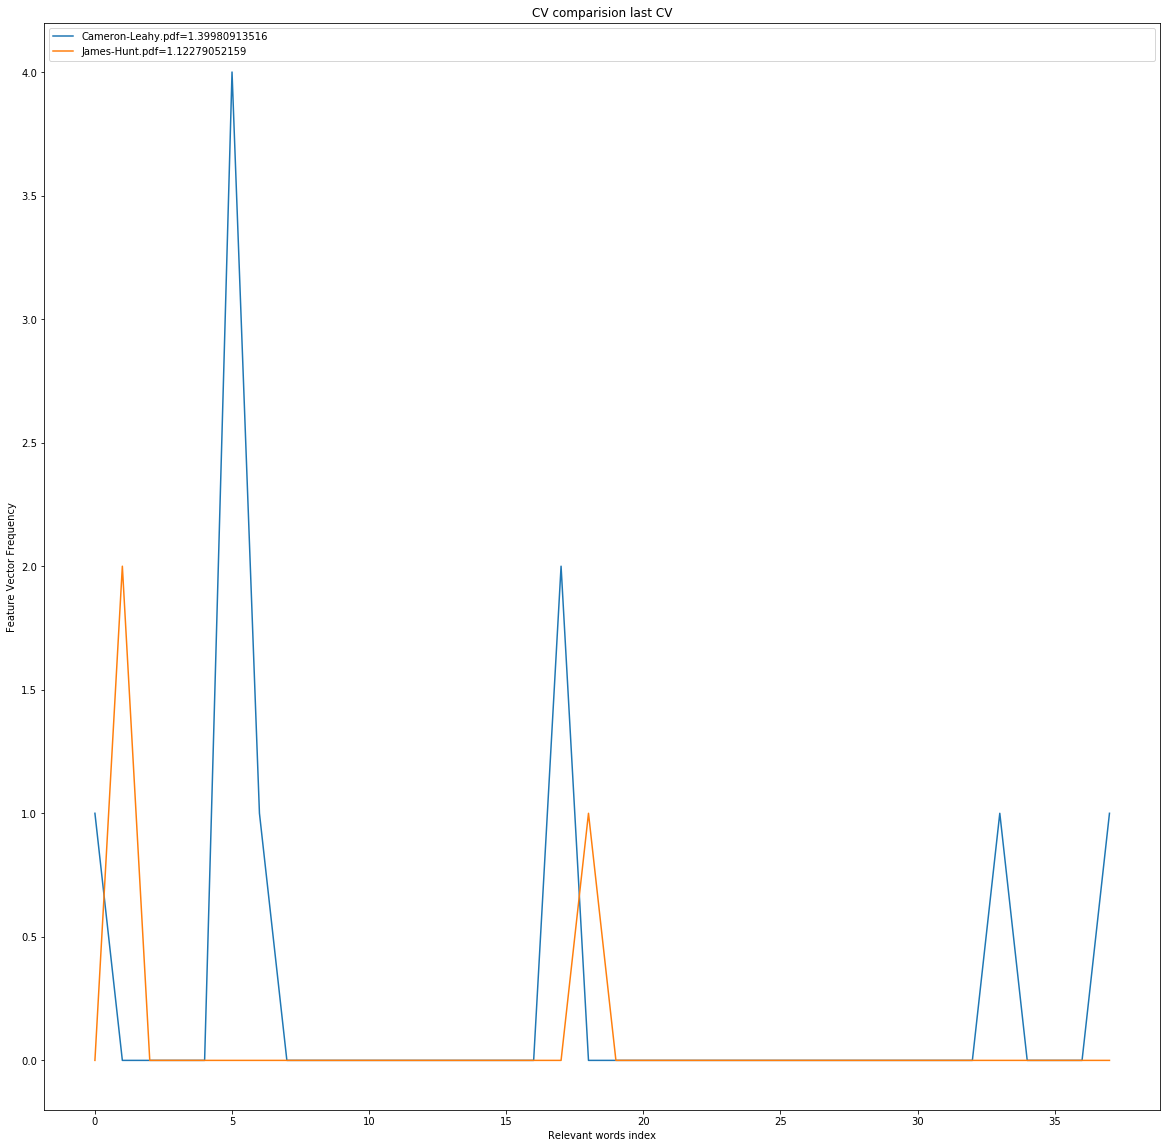

In [19]:
root=Tk()
graphics=GUI(root)
root.geometry("700x600")
root.mainloop()